In [20]:
import cv2 as cv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

tf.keras.backend.set_floatx('float32')

In [2]:
train_index = ["A-7", "A-15", "B-11", "H-15", "F-9", "G-3"]
path_cores = "TMA_cores_M06_M07_panels/M06/Cores/"
path_mxIF = "Texts_small_coregistered/"

In [3]:
train_cores = [cv.imread(path_cores + index + ".png") for index in train_index]
train_mxIF = [pd.read_csv(path_mxIF + index + ".csv") for index in train_index]

In [4]:
BUFFER = 50
BATCH = 32
VAL_SPLIT = 0.04
CELL_SIZE = (32, 32)
MXIF_FEATURES = ["Nucleus PD1 (PPD520) Mean (Normalized Counts, Total Weighting)",
                 "Nucleus PD1 (PPD520) Max (Normalized Counts, Total Weighting)",
                 "Nucleus PD1 (PPD520) Std Dev (Normalized Counts, Total Weighting)",
                 "Nucleus FOXP3 (PPD540) Mean (Normalized Counts, Total Weighting)",
                 "Nucleus FOXP3 (PPD540) Max (Normalized Counts, Total Weighting)",
                 "Nucleus FOXP3 (PPD540) Std Dev (Normalized Counts, Total Weighting)",
                 "Nucleus CD20 (PPD620) Mean (Normalized Counts, Total Weighting)",
                 "Nucleus CD20 (PPD620) Max (Normalized Counts, Total Weighting)",
                 "Nucleus CD20 (PPD620) Std Dev (Normalized Counts, Total Weighting)",
                 "Nucleus CD3 (PPD650) Mean (Normalized Counts, Total Weighting)",
                 "Nucleus CD3 (PPD650) Max (Normalized Counts, Total Weighting)",
                 "Nucleus CD3 (PPD650) Std Dev (Normalized Counts, Total Weighting)",
                 "Nucleus PANCK (PPD690) Mean (Normalized Counts, Total Weighting)",
                 "Nucleus PANCK (PPD690) Max (Normalized Counts, Total Weighting)",
                 "Nucleus PANCK (PPD690) Std Dev (Normalized Counts, Total Weighting)",
                 "Cytoplasm PD1 (PPD520) Mean (Normalized Counts, Total Weighting)",
                 "Cytoplasm PD1 (PPD520) Max (Normalized Counts, Total Weighting)",
                 "Cytoplasm PD1 (PPD520) Std Dev (Normalized Counts, Total Weighting)",
                 "Cytoplasm FOXP3 (PPD540) Mean (Normalized Counts, Total Weighting)",
                 "Cytoplasm FOXP3 (PPD540) Max (Normalized Counts, Total Weighting)",
                 "Cytoplasm FOXP3 (PPD540) Std Dev (Normalized Counts, Total Weighting)",
                 "Cytoplasm CD20 (PPD620) Mean (Normalized Counts, Total Weighting)",
                 "Cytoplasm CD20 (PPD620) Max (Normalized Counts, Total Weighting)",
                 "Cytoplasm CD20 (PPD620) Std Dev (Normalized Counts, Total Weighting)",
                 "Cytoplasm CD3 (PPD650) Mean (Normalized Counts, Total Weighting)",
                 "Cytoplasm CD3 (PPD650) Max (Normalized Counts, Total Weighting)",
                 "Cytoplasm CD3 (PPD650) Std Dev (Normalized Counts, Total Weighting)",
                 "Cytoplasm PANCK (PPD690) Mean (Normalized Counts, Total Weighting)",
                 "Cytoplasm PANCK (PPD690) Max (Normalized Counts, Total Weighting)",
                 "Cytoplasm PANCK (PPD690) Std Dev (Normalized Counts, Total Weighting)"]

In [5]:
TOTAL_MAX = np.zeros(len(MXIF_FEATURES))
TOTAL_MIN = np.zeros(len(MXIF_FEATURES))

for i, feature in enumerate(MXIF_FEATURES):
    for core in train_mxIF:
        current_max = core.loc[:,feature].max()
        current_min = core.loc[:,feature].min()
        if current_max > TOTAL_MAX[i]:
            TOTAL_MAX[i] = current_max
        if current_min < TOTAL_MIN[i]:
            TOTAL_MIN[i] = current_min

In [6]:
def get_generator(val=False):
    def data_generator():
        np.random.seed(4)
        for i in range(len(train_index)):
            X = train_mxIF[i].loc[:,'Cell X Position']
            Y = train_mxIF[i].loc[:,'Cell Y Position']

            inx = np.random.uniform(size=X.size) > VAL_SPLIT
            if val:
                inx = np.invert(inx)

            rows = np.arange(X.size)

            for j,x,y in zip(rows[inx],X[inx],Y[inx]):
                x = float(x)
                y = float(y)
                if np.isnan(x) or np.isnan(y):
                    continue
                if round(x - CELL_SIZE[0]) < 0 or round(x + CELL_SIZE[0]) >= train_cores[i].shape[1]:
                    continue
                if round(y - CELL_SIZE[1]) < 0 or round(y + CELL_SIZE[1]) >= train_cores[i].shape[0]:
                    continue

                cell_image = train_cores[i][round(y-CELL_SIZE[1]):round(y+CELL_SIZE[1]),
                                            round(x-CELL_SIZE[0]):round(x+CELL_SIZE[0])] / 255
                
                cell_features = np.array(train_mxIF[i].loc[j, MXIF_FEATURES], dtype=np.float32)
                cell_features = (cell_features - TOTAL_MIN) / TOTAL_MAX
                
                if np.sum(np.isnan(cell_features)) != 0:
                    continue

                yield (cell_image, cell_features), (cell_image, cell_features)
                
    return data_generator


In [7]:
train_ds = tf.data.Dataset.from_generator(get_generator(),
                    output_signature=((tf.TensorSpec(shape=(2*CELL_SIZE[1],2*CELL_SIZE[0],3), dtype=tf.float32),tf.TensorSpec(shape=(len(MXIF_FEATURES)), dtype=tf.float32)),
                    (tf.TensorSpec(shape=(2*CELL_SIZE[1],2*CELL_SIZE[0],3), dtype=tf.float32),
                    tf.TensorSpec(shape=(len(MXIF_FEATURES)), dtype=tf.float32))))
val_ds = tf.data.Dataset.from_generator(get_generator(val=True),
                    output_signature=((tf.TensorSpec(shape=(2*CELL_SIZE[1],2*CELL_SIZE[0],3), dtype=tf.float32),tf.TensorSpec(shape=(len(MXIF_FEATURES)), dtype=tf.float32)),
                    (tf.TensorSpec(shape=(2*CELL_SIZE[1],2*CELL_SIZE[0],3), dtype=tf.float32),
                    tf.TensorSpec(shape=(len(MXIF_FEATURES)), dtype=tf.float32))))
train_ds = train_ds.shuffle(BUFFER)
train_ds = train_ds.batch(BATCH)
val_ds = val_ds.batch(BATCH)

2023-03-09 06:13:51.022101: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/leonkl/anaconda3/envs/LAB/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-09 06:13:51.022124: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-09 06:13:51.022139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (icme-gpu1): /proc/driver/nvidia/version does not exist
2023-03-09 06:13:51.022429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorF

In [8]:
class DoubleAutoencoder(tf.keras.models.Model):
    def __init__(self, latent_dim=(48, 16)):
        super(DoubleAutoencoder, self).__init__()
        self.latent_dim_conv = latent_dim[0]
        self.latent_dim_fnn = latent_dim[1]
        
        self.encoder_conv = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(2*CELL_SIZE[1], 2*CELL_SIZE[0], 3)),
            tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=12, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=18, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=24, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=36, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=48, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.latent_dim_conv)])

        self.decoder_conv = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.latent_dim_conv)),
            tf.keras.layers.Dense(units=48, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(1, 1, 48)),
            tf.keras.layers.Conv2DTranspose(filters=36, kernel_size=3, 
                                            strides=(2, 2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(filters=24, kernel_size=3, 
                                            strides=(2, 2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(filters=18, kernel_size=3, 
                                            strides=(2, 2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(filters=12, kernel_size=3, 
                                            strides=(2, 2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(filters=6, kernel_size=3, 
                                            strides=(2, 2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, 
                                            strides=(2, 2), padding='same', activation='sigmoid')])
        
        self.encoder_fnn = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(len(MXIF_FEATURES))),
            tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=self.latent_dim_fnn, activation='relu', kernel_regularizer='l2')
        ])

        self.decoder_fnn = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.latent_dim_fnn)),
            tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=len(MXIF_FEATURES), activation='sigmoid', kernel_regularizer='l2')
        ])

    def call(self, inputs):
        he_latent = self.encoder_conv(inputs[0])
        mxIF_latent = self.encoder_fnn(inputs[1])
        he = self.decoder_conv(he_latent)
        mxIF = self.decoder_fnn(mxIF_latent)
        return he, mxIF


In [9]:
model = DoubleAutoencoder()
for x, y in val_ds.take(1):
    model(x)
model.summary()

Model: "double_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 48)                32850     
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         32805     
                                                                 
 sequential_2 (Sequential)   (None, 16)                4976      
                                                                 
 sequential_3 (Sequential)   (None, 30)                4990      
                                                                 
Total params: 75,621
Trainable params: 74,853
Non-trainable params: 768
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [ ]:
log_dir = "logs/autoencoder/baseline/l2_reg_mxIF_encoder"
log_dir_train = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir_train, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               restore_best_weights=True, patience=10,
                               verbose=0, mode='min')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(log_dir_train, monitor='val_loss',
                                verbose = 0, save_best_only=True)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                                 patience=3, verbose=0)

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=25, shuffle=True, verbose=2,
          callbacks=[tensorboard, early_stopping, model_checkpoint, lr_reduce])

Epoch 1/10
    469/Unknown - 51s 102ms/step - loss: 0.1168 - output_1_loss: 0.0508 - output_2_loss: 0.0660 - output_1_mean_squared_error: 0.0508 - output_2_mean_squared_error: 0.0660

KeyboardInterrupt: 

In [10]:
loaded_model = tf.saved_model.load("logs/autoencoder/baseline/20230308-225038/")

In [18]:
for i, elem in enumerate(val_ds):
    if i == 100:
        predict = loaded_model(elem[0])
        for j in range(32):
            cv.imwrite("original{}.png".format(j), elem[0][0][j].numpy()*255)
            cv.imwrite("predict{}.png".format(j), predict[0][j].numpy()*255)
        print(elem[0][1][1])
        print(predict[1][:].shape)
        

tf.Tensor(
[0.00480221 0.01547084 0.00777299 0.00745246 0.01480864 0.0111446
 0.00069506 0.00344031 0.00247465 0.00447166 0.00841323 0.00710877
 0.00032147 0.00962382 0.00282416 0.00449698 0.01060935 0.00526338
 0.01186472 0.01473578 0.00988884 0.00096941 0.00348961 0.00271179
 0.00665589 0.00939234 0.00592044 0.00046264 0.00507449 0.00237172], shape=(30,), dtype=float32)
(32, 30)


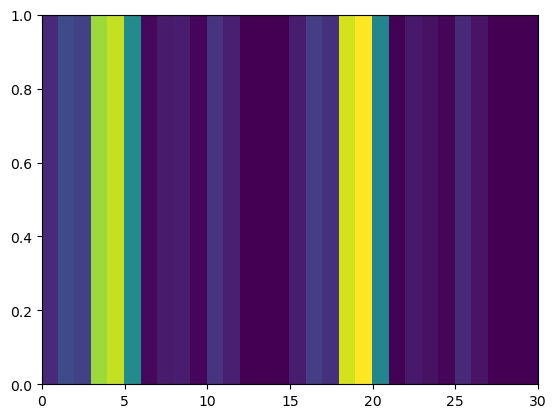

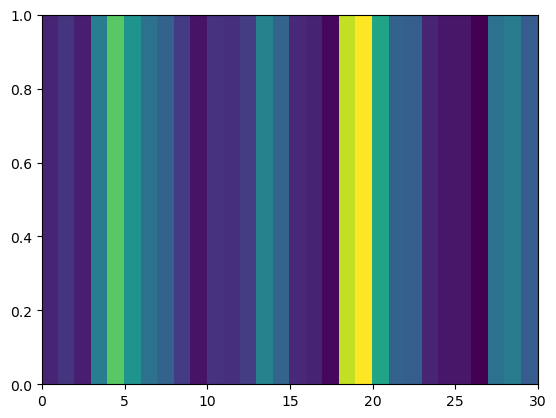

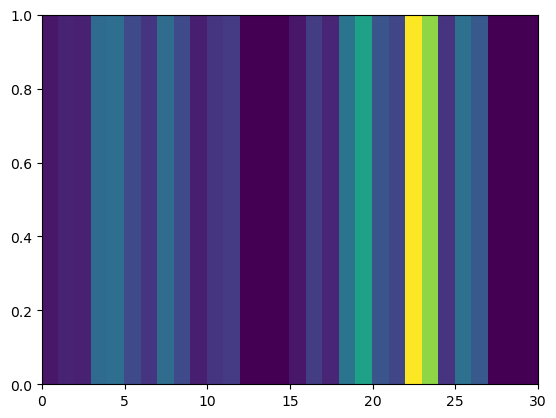

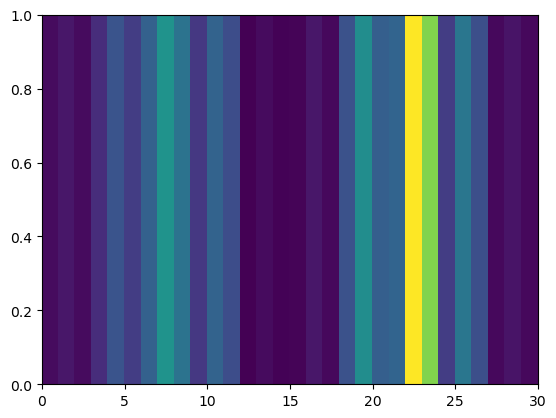

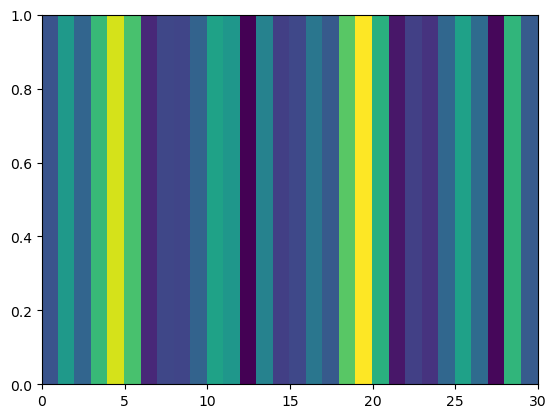

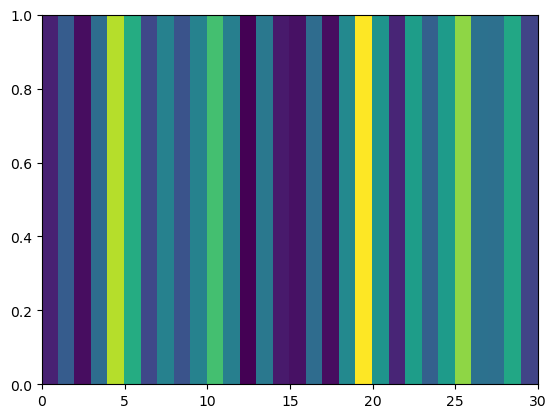

In [35]:
for elem in val_ds.take(3):
    predict = loaded_model(elem[0])
    plt.figure()
    plt.pcolor(elem[0][1][22][None])
    plt.show()
    plt.figure()
    plt.pcolor(predict[1][22][None])
    plt.show()
    
